Simulation de differentes identification de processus

SOPDT (DBR)
FOPDT (DBR)
BROIDA
VAN DER GRINTEN
STREJC

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

import package_DBR
from package_DBR import myRound, SelectPath_RT, FOPDT, FOPDT_cost, SOPDT, SOPDT_cost, Process, Bode
import package_LAB
from package_LAB import LeadLag_RT, PID_RT

from importlib import reload
package_LAB = reload(package_LAB)

DATA_LOADING + PLOTS

In [7]:
nameFile = 'Open_loop_experiment_on_MV_2022-04-19-11h17.txt'

if 'MV' in nameFile:
    ExpVariable = 'MV'
else:    
    ExpVariable = 'DV'
    
print(ExpVariable)    
    
titleName = nameFile.split('.')[0]    
data = pd.read_csv('Data/' + nameFile)
t = data['t'].values - data['t'].values[0]
MV = data['MV'].values
PV = data['PV'].values
DV = data['DV'].values

MV


(45.0, 55.0)

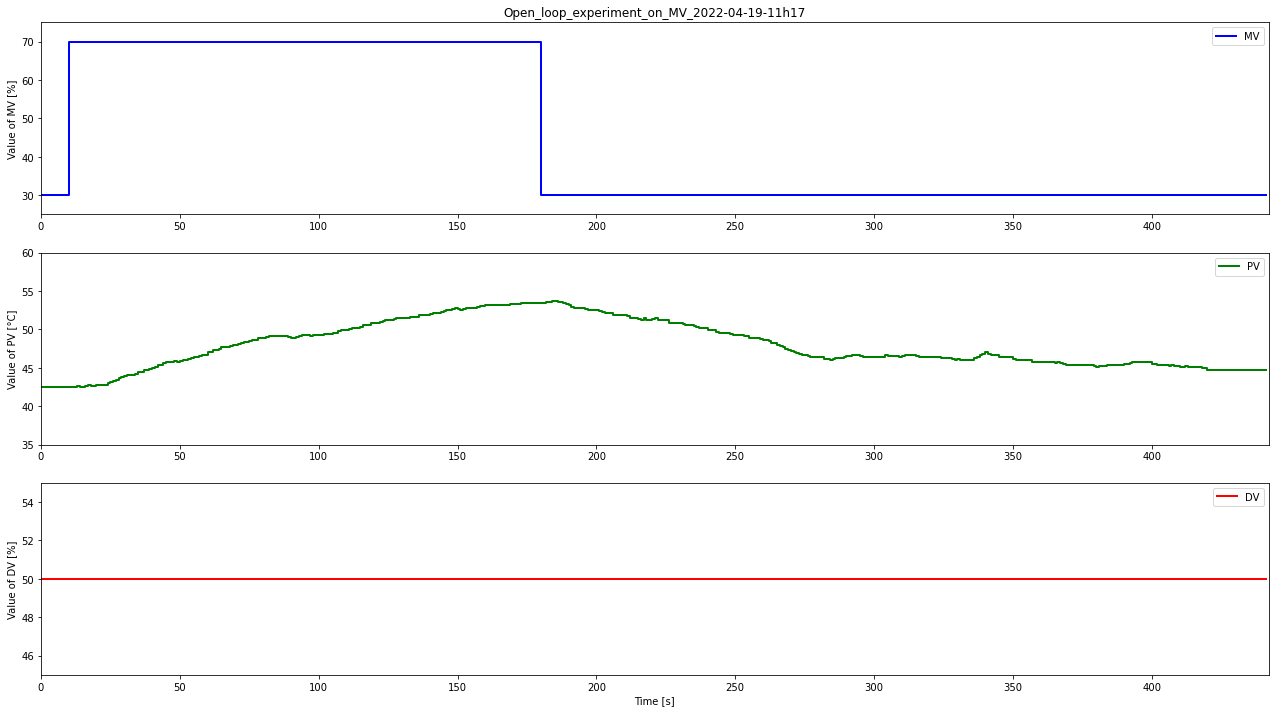

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='MV',where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.set_title(titleName)
ax1.legend(loc='best')

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0,1],[0,100],'r-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best')

l1.set_data(t,MV)
l2.set_data(t,PV)
l3.set_data(t,DV)

ax1.set_xlim(0, t[-1]+1)
ax2.set_xlim(0, t[-1]+1)
ax3.set_xlim(0, t[-1]+1)

ax1.set_ylim(myRound(np.min(MV),5)-5, myRound(np.max(MV),5)+5)
ax2.set_ylim(myRound(np.min(PV),5)-5, myRound(np.max(PV),5)+5)
ax3.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)

CLEAN DATA + PLOTS

In [9]:
if ExpVariable == 'MV':
    tstep = np.argwhere(np.diff(MV) != 0)
    tstep = tstep[0][0]
    tm = t[tstep:]
    tm = tm - tm[0]    
    MVstep = MV[tstep + 1] - MV[tstep]
    MVm = MV[tstep:]
    PVm = PV[tstep:]
    PVm = (PVm - PVm[0])/MVstep
    MVm = (MVm - MVm[0])/MVstep    
else:    
    tstep = np.argwhere(np.diff(DV) != 0)
    tstep = tstep[0][0]
    tm = t[tstep:]
    tm = tm - tm[0]
    DVstep = DV[tstep + 1] - DV[tstep]    
    DVm = DV[tstep:]
    PVm = PV[tstep:]
    PVm = (PVm - PVm[0])/DVstep
    DVm = (DVm - DVm[0])/DVstep

(0.0, 442.0)

<Figure size 1584x1584 with 0 Axes>

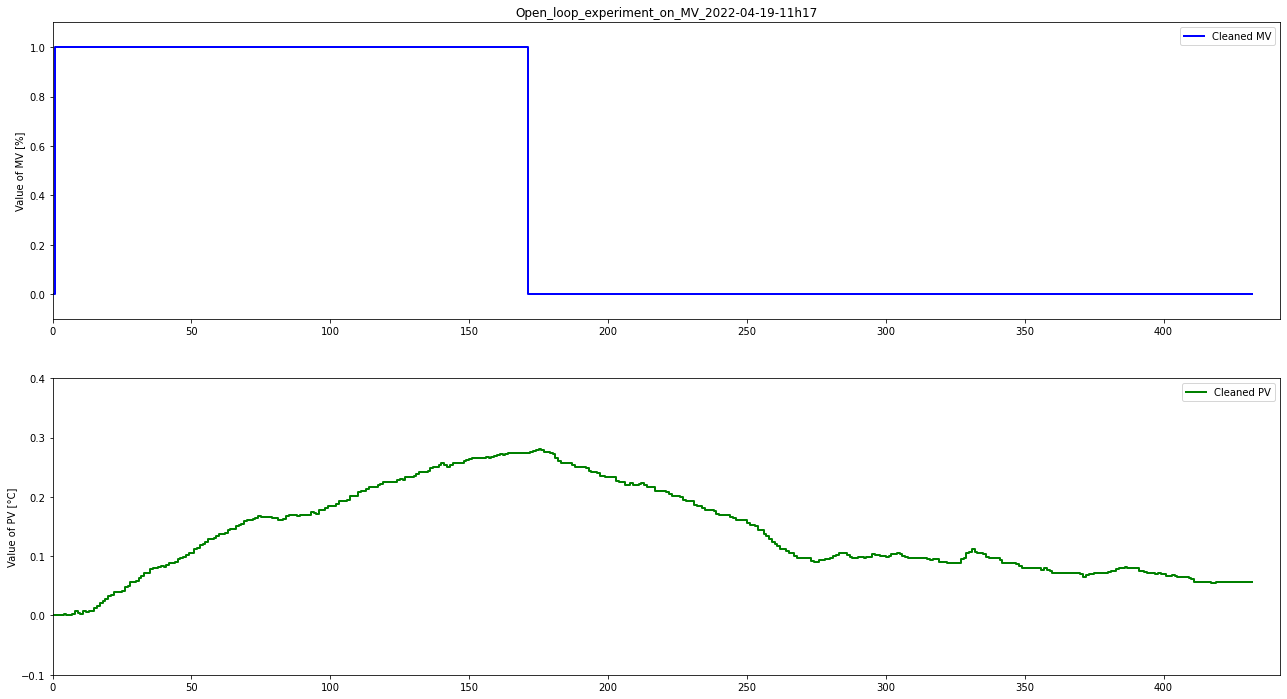

In [10]:
plt.figure(figsize = (22,22))

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_figheight(12)
fig.set_figwidth(22)

if ExpVariable == 'MV':
    l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='Cleaned MV',where='post')
    ax1.set_ylabel('Value of MV [%]')
    ax1.set_title(titleName)
    ax1.legend(loc='best')
    l1.set_data(tm,MVm)
    ax1.set_ylim(myRound(np.min(MVm),1)-0.1, myRound(np.max(MVm),1)+0.1)    
else:
    l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='Cleaned DV',where='post')
    ax1.set_ylabel('Value of DV [%]')
    ax1.set_title(titleName)
    ax1.legend(loc='best')
    l1.set_data(tm,DVm)
    ax1.set_ylim(myRound(np.min(DVm),1)-0.1, myRound(np.max(DVm),1)+0.1)     

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='Cleaned PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')
l2.set_data(tm,PVm)
ax2.set_ylim(myRound(np.min(PVm),0.1)-0.1, myRound(np.max(PVm),0.1)+0.1)

ax1.set_xlim(0, t[-1]+1)
ax2.set_xlim(0, t[-1]+1)

IDENTIFICATION FOPDT

In [11]:
Ts = 1.0

maxIter = 500

#FOPDT
p0 = np.zeros(3)
p0[0] = 0.5 # K
p0[1] = 100.0 # T
p0[2] = 10.0 # theta


bnds = ((None, None), (0, None), (0, None))

if ExpVariable == 'MV':
    cost_FOPDT = FOPDT_cost(p0,MVm,PVm,Ts)
else:
    cost_FOPDT = FOPDT_cost(p0,DVm,PVm,Ts)
    
print('Initial FOPDT cost: ' + str(cost_FOPDT))

solution_FOPDT = minimize(FOPDT_cost,p0,args=(MVm,PVm,Ts), method='Powell', bounds=bnds, options={'disp': True})
p_fopdt = solution_FOPDT.x
print('Final SSE Objective FOPDT: ' + str(FOPDT_cost(p_fopdt,MVm,PVm,Ts)))

K_FOPDT = p_fopdt[0]
T_FOPDT = p_fopdt[1]
theta_FOPDT  = p_fopdt[2]

print('K: ' + str(K_FOPDT))
print('T: ' + str(T_FOPDT))
print('theta: ' + str(theta_FOPDT))


Initial FOPDT cost: 2.1397744953525932
Optimization terminated successfully.
         Current function value: 0.068612
         Iterations: 8
         Function evaluations: 443
Final SSE Objective FOPDT: 0.06861210446644299
K: 0.3874168772106143
T: 134.8626375752049
theta: 4.909846646382664


IDENTIFICATION SOPDT

In [12]:
#SOPDT

p1 = np.zeros(4)
p1 [0] = 0.65 # K
p1 [1] = 100.0 # T1
p1 [2] = 20.0 # T2
p1 [3] = 10.0 # theta

bnds = ((None, None), (0, None), (0, None), (0, None))

if ExpVariable == 'MV':
    cost_SOPDT = SOPDT_cost(p1 ,MVm,PVm,Ts)
else:
    cost_SOPDT = SOPDT_cost(p1 ,DVm,PVm,Ts)
    
print('Initial SOPDT cost: ' + str(cost_SOPDT))

solution_SOPDT = minimize(SOPDT_cost,p1 ,args=(MVm,PVm,Ts), method='Powell', bounds=bnds, options={'disp': True})
p_sopdt = solution_SOPDT.x
print('Final SSE Objective SOPDT: ' + str(SOPDT_cost(p_sopdt,MVm,PVm,Ts)))

K_SOPDT = p_sopdt[0]
T1_SOPDT = p_sopdt[1]
T2_SOPDT = p_sopdt[2]
theta_SOPDT  = p_sopdt[3]

print('K: ' + str(K_SOPDT ))
print('T1: ' + str(T1_SOPDT ))
print('T2: ' + str(T2_SOPDT ))
print('theta: ' + str(theta_SOPDT ))

Initial SOPDT cost: 7.717529845813214
Optimization terminated successfully.
         Current function value: 0.068593
         Iterations: 9
         Function evaluations: 619
Final SSE Objective SOPDT: 0.06859283599848416
K: 0.3870268878656955
T1: 134.48964045587033
T2: 0.18834872361511124
theta: 4.428370012941102


C:\Users\tardi\Control_theory_software\package_DBR.py:277: RuntimeWarning: overflow encountered in double_scalars
  objective = objective + (PV[i] - PVSim[i])**2
C:\Users\tardi\Control_theory_software\package_DBR.py:92: RuntimeWarning: overflow encountered in double_scalars
  PV.append((1/(1+K))*PV[-1] + (K*Kp/(1+K))*MV[-1])


IDENTIFICATION BROÏDA simple (FOPDT)

In [13]:
#BROIDA simple

p2 = np.zeros(3)
p2[0] = 0.27 # K
p2[1] = 92.72 # T
p2[2] = 14.64 # theta


bnds = ((None, None), (0, None), (0, None))

if ExpVariable == 'MV':
    cost_BROIDA = FOPDT_cost(p2,MVm,PVm,Ts)
else:
    cost_BROIDA = FOPDT_cost(p2,DVm,PVm,Ts)
    
print('Initial BROIDA cost: ' + str(cost_BROIDA))

solution_BROIDA = minimize(FOPDT_cost,p2,args=(MVm,PVm,Ts), method='Powell', bounds=bnds, options={'disp': True})
p_broida = solution_BROIDA.x
print('Final SSE Objective BROIDA: ' + str(FOPDT_cost(p_broida,MVm,PVm,Ts)))

K_BROIDA = p_broida[0]
T_BROIDA = p_broida[1]
theta_BROIDA  = p_broida[2]

print('K: ' + str(K_BROIDA))
print('T: ' + str(T_BROIDA))
print('theta: ' + str(theta_BROIDA))

Initial BROIDA cost: 0.6802953941364482
Optimization terminated successfully.
         Current function value: 0.069988
         Iterations: 5
         Function evaluations: 254
Final SSE Objective BROIDA: 0.06998793475702503
K: 0.3835878144261337
T: 131.03901547620237
theta: 6.824460762219572


IDENTIFICATION BROÏDA complete (FOPDT)

In [14]:
#BROIDA complete

p3 = np.zeros(3)
p3[0] = 0.27 # K
p3[1] = 67.1 # T      [5.5*(t2-t1)]
p3[2] = 19.52 # theta [2.8*t1 - 1.8*t2]


bnds = ((None, None), (0, None), (0, None))

if ExpVariable == 'MV':
    cost_BROIDA_C = FOPDT_cost(p3,MVm,PVm,Ts)
else:
    cost_BROIDA_C = FOPDT_cost(p3,DVm,PVm,Ts)
    
print('Initial BROIDA Complete cost: ' + str(cost_BROIDA_C))

solution_BROIDA_C = minimize(FOPDT_cost,p3,args=(MVm,PVm,Ts), method='Powell', bounds=bnds, options={'disp': True})
p_broida_c = solution_BROIDA_C.x
print('Final SSE Objective BROIDA Complete: ' + str(FOPDT_cost(p_broida_c,MVm,PVm,Ts)))

K_BROIDA_C = p_broida_c[0]
T_BROIDA_C = p_broida_c[1]
theta_BROIDA_C  = p_broida_c[2]

print('K: ' + str(K_BROIDA_C))
print('T: ' + str(T_BROIDA_C))
print('theta: ' + str(theta_BROIDA_C))

Initial BROIDA Complete cost: 0.7087386492930574
Optimization terminated successfully.
         Current function value: 0.068661
         Iterations: 5
         Function evaluations: 311
Final SSE Objective BROIDA Complete: 0.06866097644075922
K: 0.3880930888375982
T: 134.73305220434685
theta: 4.44578634522351


IDENTIFICATION VDG (SOPDT)

In [15]:
p4 = np.zeros(4)
p4 [0] = 0.27 # K
p4 [1] = -13.45 # T1
p4 [2] = 53.08 # T2
p4 [3] = 70.72 # theta

bnds = ((None, None), (0, None), (0, None), (0, None))

if ExpVariable == 'MV':
    cost_VDG = SOPDT_cost(p4 ,MVm,PVm,Ts)
else:
    cost_VDG = SOPDT_cost(p4 ,DVm,PVm,Ts)
    
print('Initial VDG cost: ' + str(cost_VDG))

solution_VDG = minimize(SOPDT_cost,p4 ,args=(MVm,PVm,Ts), method='Powell', bounds=bnds, options={'disp': True})
p_vdg = solution_VDG.x
print('Final SSE Objective VDG: ' + str(SOPDT_cost(p_vdg,MVm,PVm,Ts)))

K_VDG = p_vdg[0]
T1_VDG = p_vdg[1]
T2_VDG = p_vdg[2]
theta_VDG  = p_vdg[3]

print('K: ' + str(K_VDG))
print('T1: ' + str(T1_VDG))
print('T2: ' + str(T2_VDG))
print('theta: ' + str(theta_VDG))

Initial VDG cost: 3.4954065533479477e+22
Optimization terminated successfully.
         Current function value: 10.938574
         Iterations: 2
         Function evaluations: 185
Final SSE Objective VDG: 10.938573749999957
K: -76292181.52206579
T1: 5193396567935.291
T2: 4582005709192.59
theta: 6194739643875.276


C:\Users\tardi\AppData\Local\Temp/ipykernel_7824/440807366.py:16: OptimizeWarning: Initial guess is not within the specified bounds
  solution_VDG = minimize(SOPDT_cost,p4 ,args=(MVm,PVm,Ts), method='Powell', bounds=bnds, options={'disp': True})


IDENTIFICATION STREJC (SOPDT)

In [17]:
p5 = np.zeros(4)
p5 [0] = 0.27 # K
p5 [1] = 34.1 # T1
p5 [2] = 9.3 # T2
p5 [3] = 5.34 # theta

bnds = ((None, None), (0, None), (0, None), (0, None))

if ExpVariable == 'MV':
    cost_STREJC = SOPDT_cost(p5 ,MVm,PVm,Ts)
else:
    cost_STREJC = SOPDT_cost(p5 ,DVm,PVm,Ts)
    
print('Initial STREJC cost: ' + str(cost_STREJC))

solution_STREJC = minimize(SOPDT_cost,p5 ,args=(MVm,PVm,Ts), method='Powell', bounds=bnds, options={'disp': True})
p_strejc = solution_STREJC.x
print('Final SSE Objective STREJC: ' + str(SOPDT_cost(p_strejc,MVm,PVm,Ts)))

K_STREJC = p_strejc[0]
T1_STREJC = p_strejc[1]
T2_STREJC = p_strejc[2]
theta_STREJC  = p_strejc[3]

print('K: ' + str(K_STREJC))
print('T1: ' + str(T1_STREJC))
print('T2: ' + str(T2_STREJC))
print('theta: ' + str(theta_STREJC))

Initial STREJC cost: 2.005522161194475
Optimization terminated successfully.
         Current function value: 0.071400
         Iterations: 10
         Function evaluations: 820
Final SSE Objective STREJC: 0.07140047310765932
K: 0.38030460031075186
T1: 127.95408835875642
T2: 1.676209349002044e-12
theta: 5.471914867462971


(0.0, 441.0)

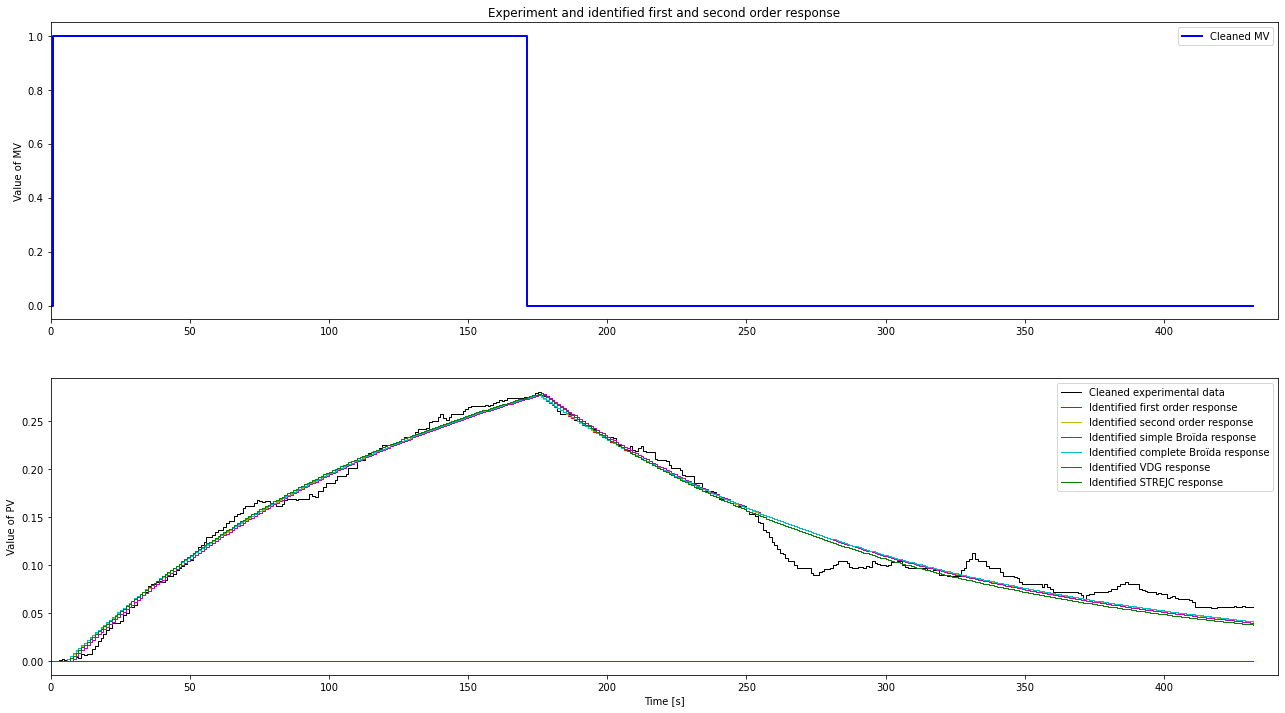

In [18]:
if ExpVariable == 'MV':
    PVSim_fopdt = FOPDT(MVm,K_FOPDT,T_FOPDT,theta_FOPDT,Ts)
    PVSim_sopdt = SOPDT(MVm,K_SOPDT,T1_SOPDT,T2_SOPDT,theta_SOPDT,Ts)
    PVSim_broida = FOPDT(MVm,K_BROIDA,T_BROIDA,theta_BROIDA,Ts)
    PVSim_broida_c = FOPDT(MVm,K_BROIDA_C,T_BROIDA_C,theta_BROIDA_C,Ts)
    PVSim_vdg = SOPDT(MVm,K_VDG,T1_VDG,T2_VDG,theta_VDG,Ts)
    PVSim_strejc = SOPDT(MVm,K_STREJC,T1_STREJC,T2_STREJC,theta_STREJC,Ts)
else:
    PVSim_fopdt = FOPDT(DVm,K_FOPDT,T_FOPDT,theta_FOPDT,Ts)
    PVSim_sopdt = SOPDT(DVm,K_SOPDT,T1_SOPDT,T2_SOPDT,theta_SOPDT,Ts)
    PVSim_broida = FOPDT(DVm,K_BROIDA,T_BROIDA,theta_BROIDA,Ts)
    PVSim_broida_c = FOPDT(DVm,K_BROIDA_C,T_BROIDA_C,theta_BROIDA_C,Ts)
    PVSim_vdg = SOPDT(DVm,K_VDG,T1_VDG,T2_VDG,theta_VDG,Ts)
    PVSim_strejc = SOPDT(DVm,K_STREJC,T1_STREJC,T2_STREJC,theta_STREJC,Ts)

plt.figure(figsize = (22,12))

plt.subplot(2,1,1)
if ExpVariable == 'MV':
    plt.step(tm,MVm,'b-',linewidth=2,label='Cleaned MV',where='post')
    plt.ylabel('Value of MV')
else:
    plt.step(tm,DVm,'b-',linewidth=2,label='Cleaned DV',where='post')
    plt.ylabel('Value of DV') 
    
plt.title('Experiment and identified first and second order response')
plt.legend(loc='best')
plt.xlim([0, t[-1]])

plt.subplot(2,1,2)
plt.step(tm,PVm,'k-',linewidth=1,label='Cleaned experimental data',where='post')
plt.step(tm,PVSim_fopdt,'r-',linewidth=1,label='Identified first order response',where='post')
plt.step(tm,PVSim_sopdt,'y-',linewidth=1,label='Identified second order response',where='post')
plt.step(tm,PVSim_broida,'m-',linewidth=1,label='Identified simple Broïda response',where='post')
plt.step(tm,PVSim_broida_c,'c-',linewidth=1,label='Identified complete Broïda response',where='post')
plt.step(tm,PVSim_vdg,'g-',linewidth=1,label='Identified VDG response',where='post')
plt.step(tm,PVSim_strejc,'g-',linewidth=1,label='Identified STREJC response',where='post')

plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, t[-1]])

BODE DIAGRAM

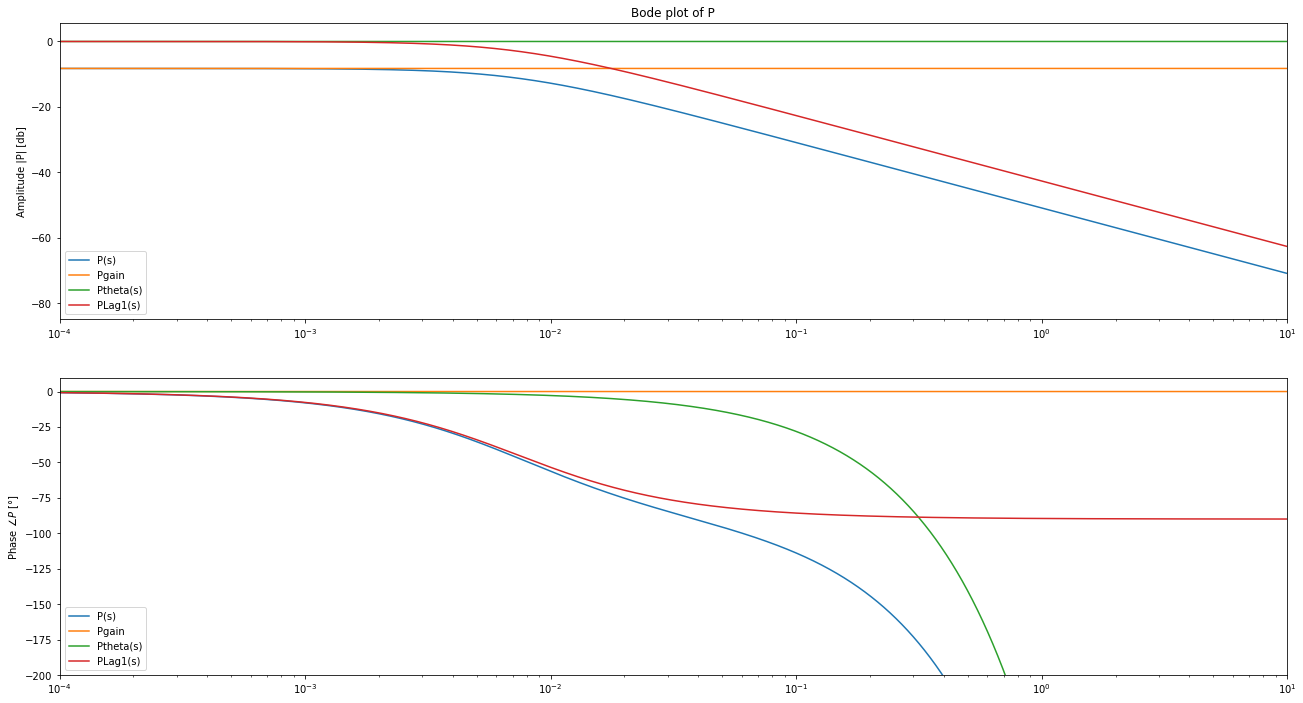

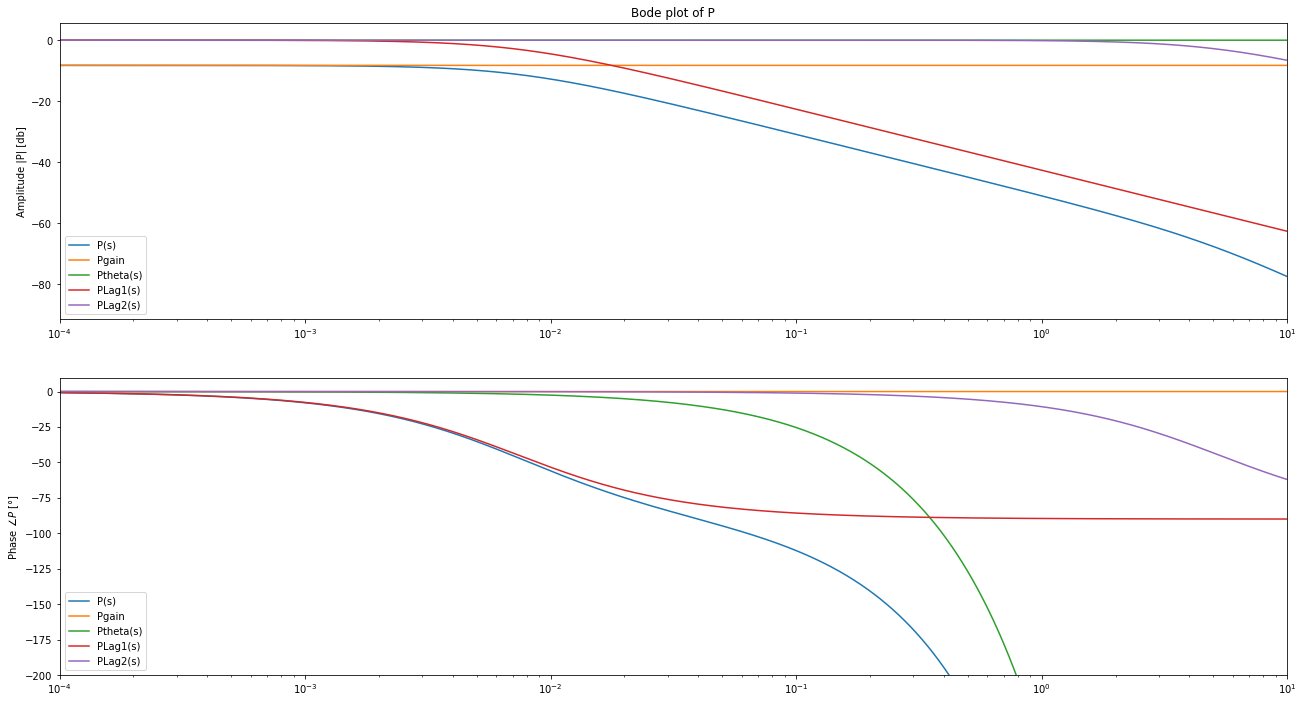

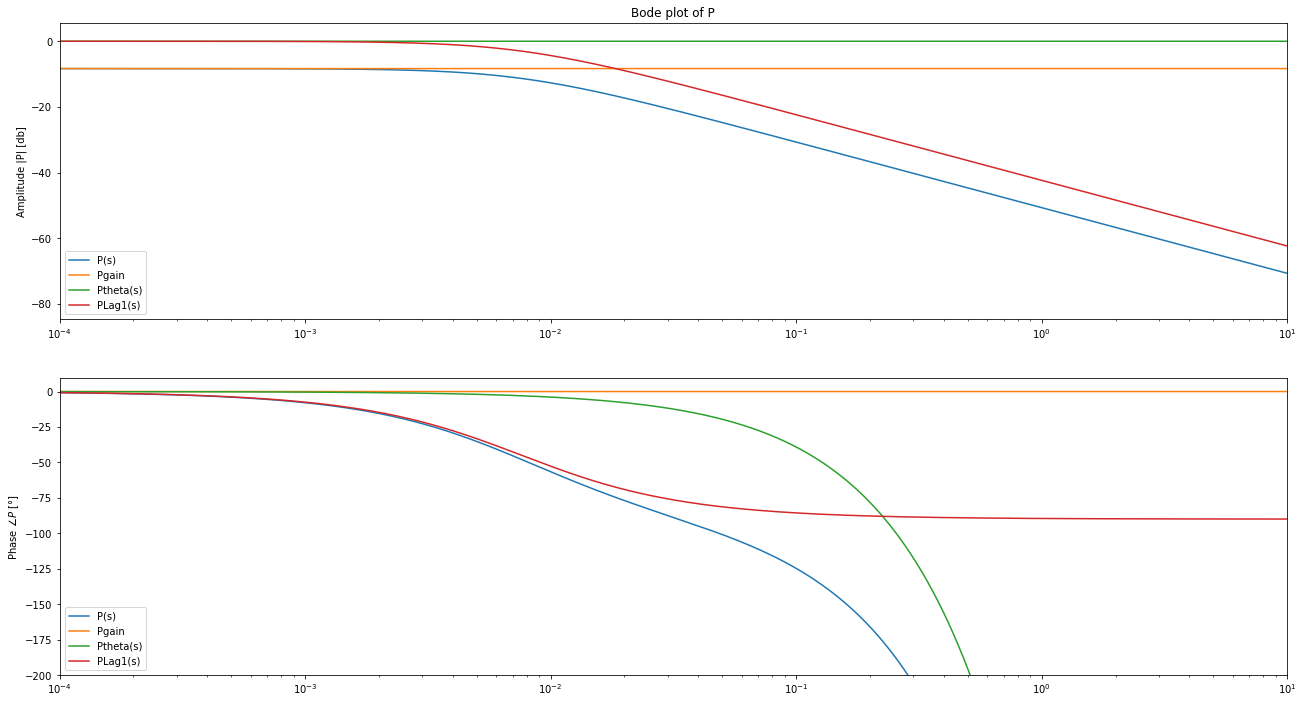

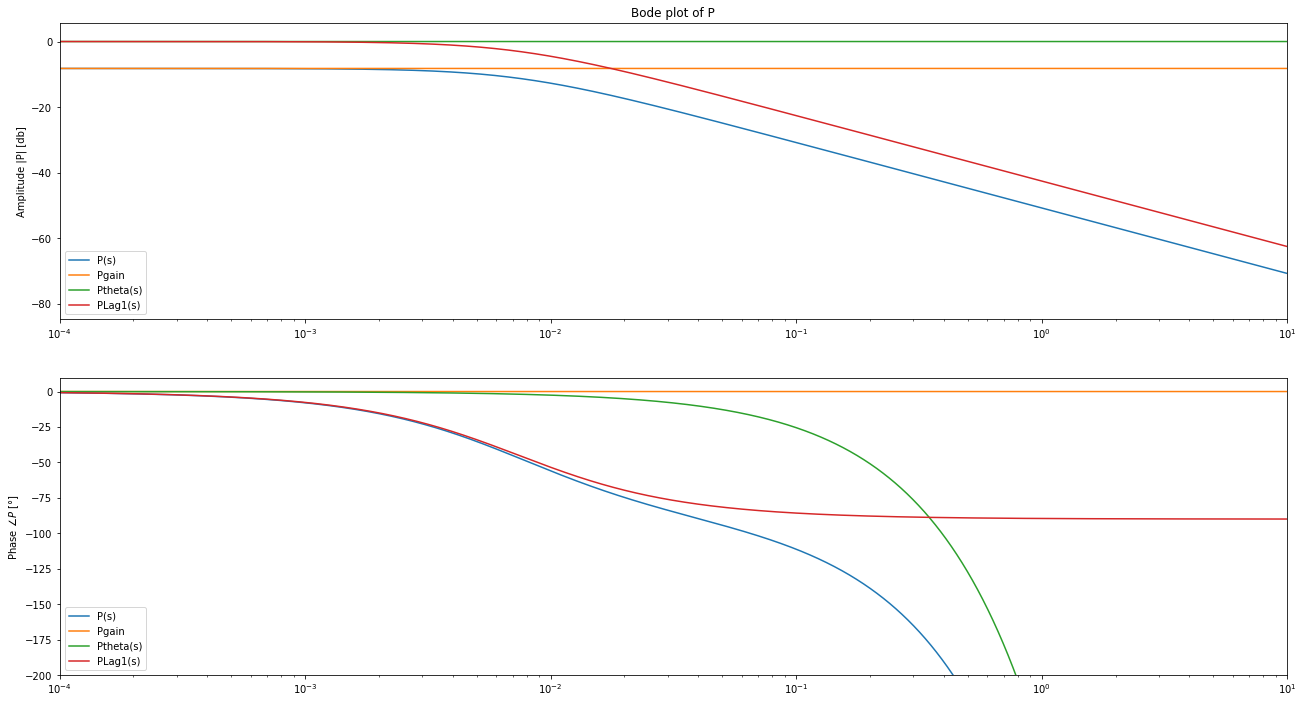

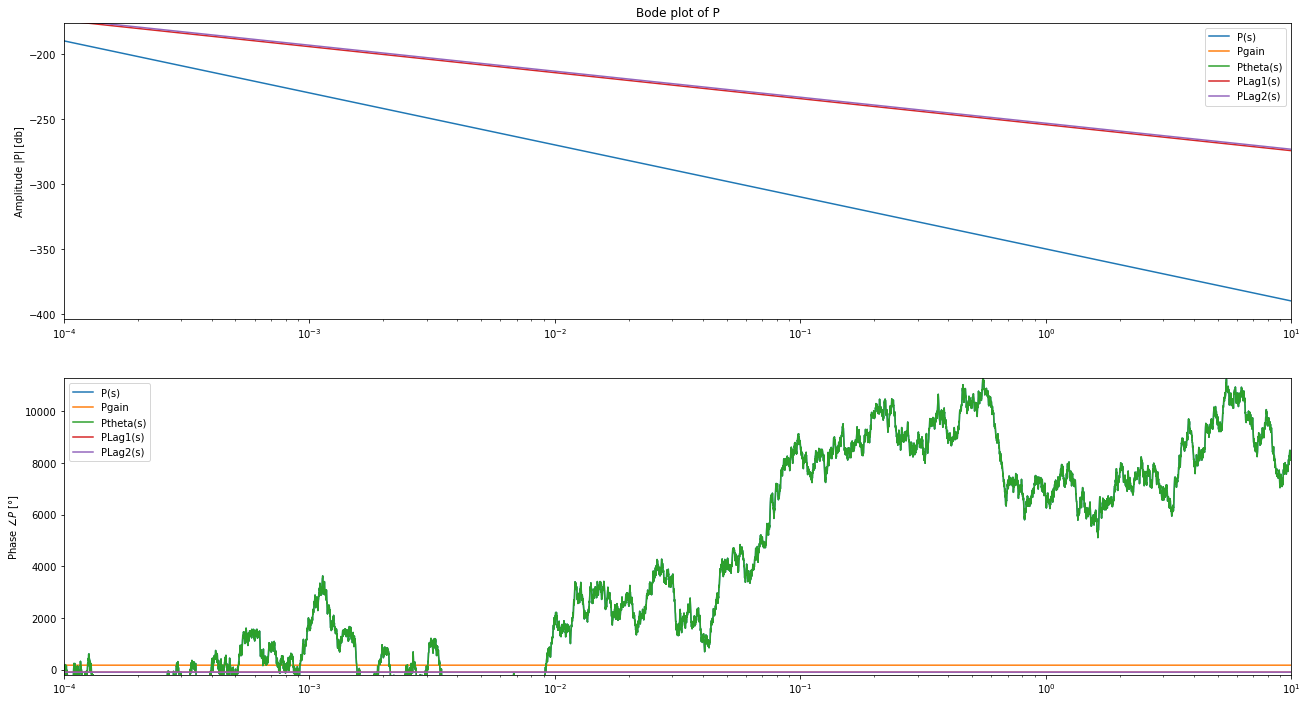

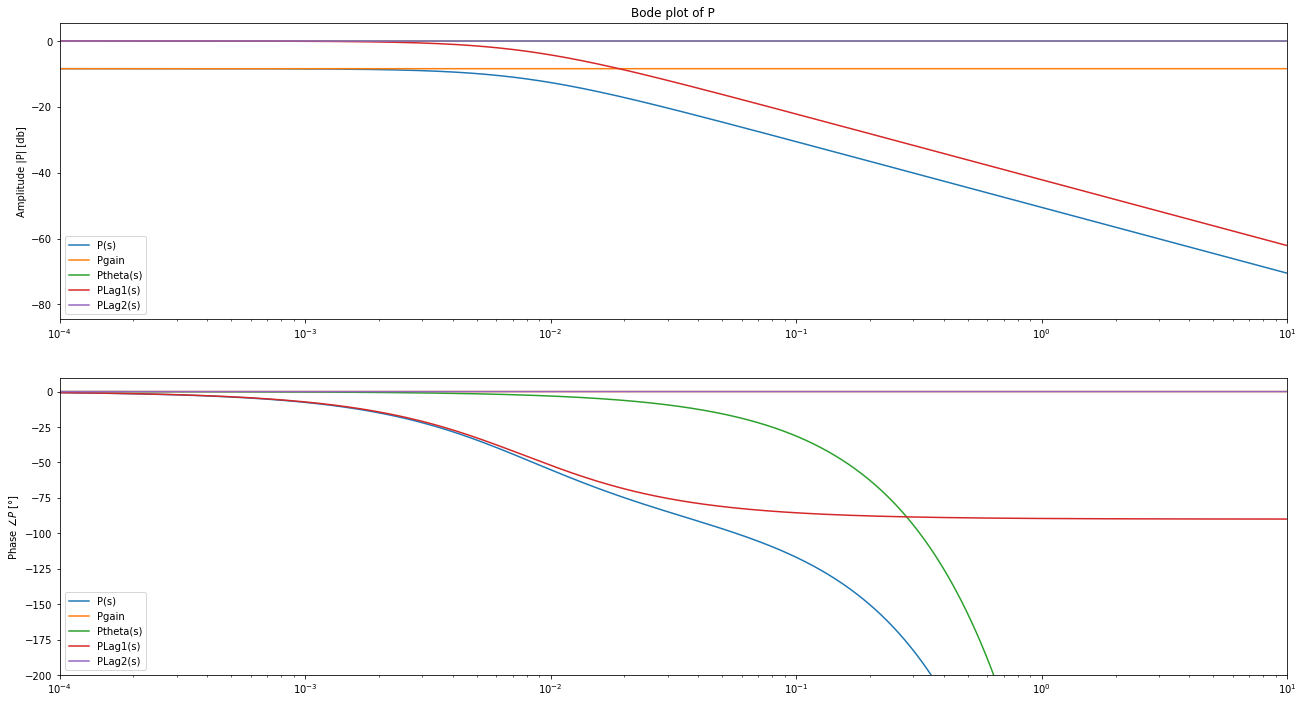

In [26]:

#FOPDT
P_fopdt = Process({}) # Default process = unit gain
# Parameters for input-output dynamics P(s)
P_fopdt.parameters['Kp'] = K_FOPDT
P_fopdt.parameters['Tlag1'] = T_FOPDT
P_fopdt.parameters['theta'] = theta_FOPDT

#SOPDT
P_sopdt = Process({}) # Default process = unit gain
P_sopdt.parameters['Kp'] = K_SOPDT
P_sopdt.parameters['Tlag1'] = T1_SOPDT
P_sopdt.parameters['Tlag2'] = T2_SOPDT
P_sopdt.parameters['theta'] = theta_SOPDT

#BROIDA
P_broida = Process({}) # Default process = unit gain
P_broida.parameters['Kp'] = K_BROIDA
P_broida.parameters['Tlag1'] = T_BROIDA
P_broida.parameters['theta'] = theta_BROIDA

#BROIDA_COMPLETE
P_broida_c = Process({}) # Default process = unit gain
P_broida_c.parameters['Kp'] = K_BROIDA_C
P_broida_c.parameters['Tlag1'] = T_BROIDA_C
P_broida_c.parameters['theta'] = theta_BROIDA_C

#VDG
P_vdg = Process({}) # Default process = unit gain
P_vdg.parameters['Kp'] = K_VDG
P_vdg.parameters['Tlag1'] = T1_VDG
P_vdg.parameters['Tlag2'] = T2_VDG
P_vdg.parameters['theta'] = theta_VDG

#STREJC
P_strejc = Process({}) # Default process = unit gain
P_strejc.parameters['Kp'] = K_STREJC
P_strejc.parameters['Tlag1'] = T1_STREJC
P_strejc.parameters['Tlag2'] = T2_STREJC
P_strejc.parameters['theta'] = theta_STREJC

omega = np.logspace(-4, 1, 10000)
Bode(P_fopdt,omega)
Bode(P_sopdt,omega)
Bode(P_broida,omega)
Bode(P_broida_c,omega)
Bode(P_vdg,omega)
Bode(P_strejc,omega)